In [1]:
# installing required library
from IPython.display import clear_output
!pip install import-ipynb 
clear_output()

In [2]:
# importing necessary libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import models, transforms
from torch import nn
from PIL import Image
from torch.nn import functional as F
import import_ipynb # to import functions from another ipynb file 

In [3]:
# mount colab to drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# import utils.ipynb file 
%cd /content/gdrive/MyDrive/object_detection
import utils

%cd /content

/content/gdrive/MyDrive/object_detection
importing Jupyter notebook from utils.ipynb
/content


In [5]:
# defining the device
device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


In [6]:
# defining the model same as the model defined while training the dataset 
model = models.resnet18(pretrained = True)

for param in model.parameters():
  param.requires_grad = False

classifier = nn.Sequential(nn.Linear(512, 512), 
                     nn.ReLU(), 
                     nn.Dropout(0.2),
                     nn.Linear(512, 256), 
                     nn.ReLU(), 
                     nn.Dropout(0.2), 
                     nn.Linear(256, 2)
                     )

model.fc = classifier
model.to(device)
clear_output()

In [7]:
# loading the best model parameters 
model.load_state_dict(torch.load('/content/gdrive/MyDrive/object_detection/model1.pt'))

<All keys matched successfully>

In [8]:
# normalize the image with the same std and mean used during training  
image_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])])


def testing_image(im, threshold):

  ''' input: 
      im: image, threshold: to select bounding boxes with object score > threshold
      returns list of bounding boxes and list of scores'''
  model.eval()
  im = cv2.imread(im)
  cv2.setUseOptimized(True);
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  if len(im.shape) == 2:
    im = cv2.merge(im, im, im)
  ss.setBaseImage(im)
  ss.switchToSelectiveSearchFast()
  rects = ss.process()

  bounding_boxes = []
  scores = []

  for count, rect in enumerate(rects):

    x, y, w, h = rect
    
    image = im.copy()
    image = image[y:y+h, x:x+w, :]
    resized_image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
    resized_image = Image.fromarray(resized_image)
    transformed_image = image_transform(resized_image)
    transformed_image = transformed_image.to(device)
    transformed_image = transformed_image[None, :]
    logits = model(transformed_image)
    probability = F.softmax(logits, dim = 1)

    if np.round(probability[0][1].item(), 2) > threshold:
      scores.append(np.round(probability[0][1].item(), 2))
      bounding_boxes.append(list(rect))
    
  return bounding_boxes, scores

In [9]:
def non_max_suppression(bounding_boxes, scores):
  ''' input: bounding_boxes and scores
      returns list of bounding boxes with maximum score for each object in an image'''

  bbox_and_scores = [list([i, j]) for i, j in zip(bounding_boxes,scores)]
  
  final_proposal = []
  while len(bbox_and_scores) != 0:
    bbox_and_scores.sort(key = lambda x: x[1], reverse = True)
    try:
      highest_score_bbox = bbox_and_scores.pop(0) 
    except:
      break
    final_proposal.append(highest_score_bbox)
    for index, (bbox, scores) in enumerate(bbox_and_scores):
      iou = utils.calculate_iou(highest_score_bbox[0], bbox)
      
      if iou > 0.1:
        bbox_and_scores.pop(index)
  return final_proposal

In [10]:
img_path = '/content/gdrive/MyDrive/object_detection/test_images/0.png'
bounding_boxes, scores = testing_image(img_path, 0.85)
final_bounding_boxes = non_max_suppression(bounding_boxes, scores)

In [11]:
old_proposal_len = -1
new_proposal_len = len(final_bounding_boxes)


while old_proposal_len != new_proposal_len:
  old_proposal_len = new_proposal_len

  final_bbox = [i for i, j in final_bounding_boxes]
  final_scores = [j for i, j in final_bounding_boxes]

  new_proposal = non_max_suppression(final_bbox, final_scores)
  new_proposal_len = len(new_proposal)
  final_bounding_boxes = new_proposal
print('total number of bounding boxes:', new_proposal_len)  


total number of bounding boxes: 3


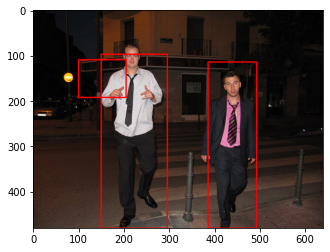

In [12]:
# drawing the bounding box for an image with the obtained bounding box coordinates from non-max suppression. 
img = plt.imread(img_path)
for i, j in final_bounding_boxes:
    cv2.rectangle(img, (i[0], i[1]), (i[0] + i[2], i[1]+ i[3]), (255, 0, 0), 2)
plt.imshow(img)